# 自行车数据模型调参

## 导入数据

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("data.csv") 
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


## 数据预处理

In [5]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### 时间处理

In [6]:
df['hour'] = pd.DatetimeIndex(df.datetime).hour
df['day'] = pd.DatetimeIndex(df.datetime).dayofweek
df['month'] = pd.DatetimeIndex(df.datetime).month
df_origin = df 
df = df.drop(['datetime','casual','registered'], axis = 1)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month
0,1,0,0,1,9.84,14.395,81,0.0,16,0,5,1
1,1,0,0,1,9.02,13.635,80,0.0,40,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2,5,1
3,1,0,0,1,9.84,14.395,75,0.0,13,3,5,1
4,1,0,0,1,9.84,14.395,75,0.0,1,4,5,1


### 划分数据

In [7]:
X = df.drop(['count'], axis = 1).values
y = df['count'].values
# 将数据分割为训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=9)

### 特征数据标准化

In [8]:
X = preprocessing.scale(X)
y = preprocessing.scale(y)

## 测试各种回归模型

In [9]:
scores = {}
cv = 8 # 交叉验证分割次数

### 岭回归

In [10]:
from sklearn import linear_model

#### cross_val_score交叉验证

In [25]:
??cross_val_score

In [11]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(linear_model.Ridge(), X, y, scoring='r2', cv=cv)
scores['linear_model'] = score
score

array([-2.20716504,  0.27449274,  0.06456714,  0.11703261,  0.09879707,
        0.23267297,  0.26340306,  0.08169815])

#### k折法交叉验证

In [26]:
??KFold

In [27]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv, shuffle=True)
for train, test in kf.split(X):
    ridgeModel = linear_model.Ridge().fit(X[train], y[train])
    # {0:.3f} 0表示第一个参数，保留三位小数，是训练集上的得分
    # {1:.3f} 1表示测试集上的得分
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        ridgeModel.score(X[train], y[train]),
        ridgeModel.score(X[test], y[test])))

train score: 0.341, test score: 0.315

train score: 0.339, test score: 0.326

train score: 0.332, test score: 0.372

train score: 0.338, test score: 0.334

train score: 0.336, test score: 0.349

train score: 0.341, test score: 0.311

train score: 0.339, test score: 0.327

train score: 0.337, test score: 0.344



### 支持向量回归

In [13]:
from sklearn import svm
svr = svm.SVR(kernel = 'rbf', C = 10, gamma = .001)
score = cross_val_score(svr, X, y, scoring='r2', cv=cv)
scores['svm.SVR'] = score
score

array([-0.7231292 ,  0.42888375,  0.38695022,  0.33716335,  0.094991  ,
        0.15303442,  0.24232796,  0.01459345])

### 随机森林回归

In [14]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100)
score = cross_val_score(rfr, X, y, scoring='r2', cv=cv)
scores['RandomForestRegressor'] = score
score

array([-1.63877024,  0.38969685,  0.45106234,  0.27170954,  0.32682855,
        0.66620213,  0.72947499,  0.63998951])

### 决策回归树

In [15]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
score = cross_val_score(tree, X, y, scoring='r2', cv=cv)
scores['DecisionTreeRegressor'] = score
score

array([-2.44333747,  0.17297724,  0.27689668, -0.08954216,  0.32502038,
        0.60614651,  0.683371  ,  0.549673  ])

### GBDT回归

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor()
score = cross_val_score(gbr, X, y, scoring='r2', cv=cv)
scores['GradientBoostingRegressor'] = score
score

array([-1.39026072,  0.49323328,  0.52746805,  0.38230082,  0.52774023,
        0.63457776,  0.62120245,  0.57049589])

### 结果分析

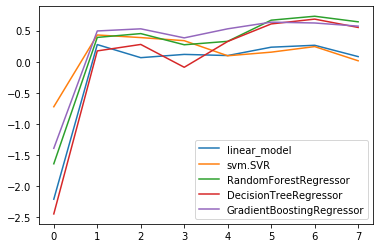

In [17]:
x = range(cv)
plt.plot(x, scores['linear_model'], label='linear_model')
plt.plot(x, scores['svm.SVR'], label='svm.SVR')
plt.plot(x, scores['RandomForestRegressor'], label='RandomForestRegressor')
plt.plot(x, scores['DecisionTreeRegressor'], label='DecisionTreeRegressor')
plt.plot(x, scores['GradientBoostingRegressor'], label='GradientBoostingRegressor')
plt.legend()

通过每个模型交叉验证后的结果，可以发现随机森林、决策回归树和GBDT回归模型相对较优。

## 模型调参和打分

In [18]:
from sklearn.model_selection import GridSearchCV

### 决策回归树

In [19]:
??DecisionTreeRegressor

In [20]:
param_grid = {
    'criterion': ['mse', 'friedman_mse'],
    'min_samples_split': range(2,10,2),
    'min_samples_leaf': range(1,5),
    'random_state': range(0,100,20)
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('最佳度量值:',grid.best_score_)  # 获取最佳度量值
print('最佳参数：',grid.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('最佳模型：',grid.best_estimator_)  # 获取最佳度量时的分类器模型

最佳度量值: 0.7732809210240961
最佳参数： {'criterion': 'mse', 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 0}
最佳模型： DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')


### 回归树模型打分

In [24]:
dtr = DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

kf = KFold(n_splits=5, shuffle=True) # 通过设置shuffle参数，防止对数据洗牌
for train, test in kf.split(X): 
    dtr.fit(X[train], y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        dtr.score(X[train], y[train]), dtr.score(X[test], y[test])))

train score: 0.934, test score: 0.778

train score: 0.933, test score: 0.790

train score: 0.934, test score: 0.798

train score: 0.935, test score: 0.763

train score: 0.937, test score: 0.819



### GBDT回归

In [34]:
??GradientBoostingRegressor

In [35]:
param_grid = {
    # GBDT算法中的损失函数
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    # n_estimators: 也就是弱学习器的最大迭代次数，或者说最大的弱学习器的个数。一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合
    'n_estimators': range(100,600,100),
    # 子采样，取值为(0,1]
    'subsample': [0.5, 0.6, 0.7, 0.8]
}
grid = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)
print('最佳度量值:',grid.best_score_)  # 获取最佳度量值
print('最佳参数：',grid.best_params_)  # 获取最佳度量值时的代定参数的值。是一个字典
print('最佳模型：',grid.best_estimator_)  # 获取最佳度量时的分类器模型

最佳度量值: 0.8522007935252116
最佳参数： {'loss': 'ls', 'n_estimators': 500, 'subsample': 0.7}
最佳模型： GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


### GBDT回归模型打分

In [36]:
gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
kf = KFold(n_splits=5, shuffle=True) # 通过设置shuffle参数，防止对数据洗牌
for train, test in kf.split(X): 
    gbr.fit(X[train], y[train])
    print("train score: {0:.3f}, test score: {1:.3f}\n".format(
        gbr.score(X[train], y[train]), gbr.score(X[test], y[test])))

train score: 0.882, test score: 0.859

train score: 0.881, test score: 0.855

train score: 0.882, test score: 0.853

train score: 0.882, test score: 0.865

train score: 0.883, test score: 0.852

